# Capítulo 2

Esta libreta contiene el código para resolver los principales aspectos del capítulo 2.
Usamos rpy2 para correr código de rethinking.

## Setup R (rpy2)

In [19]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [20]:
%%R
library(rethinking)

## Setting up python


In [1]:
import logging 

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

pm_logr = logging.getLogger('pymc')
pm_logr.setLevel(logging.WARNING)

## Proceso de actualización bayesiana.
Se explica cómo, partiendo de un prior uniforme, se actualiza la distribución posterior con base en los datos. En el ejemplo se toma el experimento de lanzar al aire un globo terráqueo y marcar como "W" cuando el índice derecho toque agua o "L" cuando toque tierra. El objetivo es estimar la proporción de agua en el globo.

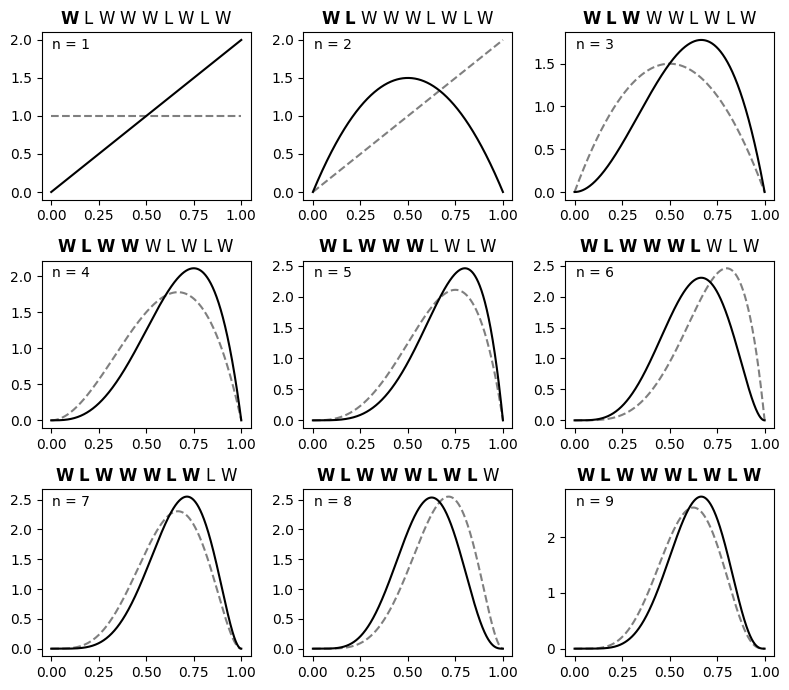

In [ ]:

x = np.linspace(0, 1, 1000)

def plot_beta(k, n, a0, b0, title=None, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
    beta_prior = stats.beta(a0, b0)
    y_prior = beta_prior.pdf(x)
    ax.plot(x, y_prior, ls='--', c='k', alpha=0.5)
    a1,b1 = a0 + k, b0 + (n-k)
    beta_post = stats.beta(a1, b1)
    y_post = beta_post.pdf(x)
    ax.plot(x, y_post, c='k')
    title = title or f'Beta({a1=},{b1=})'
    ax.set_title(title)
    n_obs = a1+b1-2
    ax.text(0.05, 0.9, f'n = {n_obs}', transform=ax.transAxes)

    return a1, b1

_, grid = plt.subplots(3, 3, figsize=(8,7))
grid = grid.flatten()
a0, b0 = 1, 1
title_base = list('WLWWWLWLW')

for i, k in enumerate((1, 0, 1, 1, 1, 0, 1, 0, 1), start=1):
    bold = r'\ '.join(title_base[:i])
    rest = ' '.join(title_base[i:])
    title = rf'$\mathbf{{{bold}}}$ {rest}'
    a0, b0 = plot_beta(k, 1, a0, b0, title=title, ax=grid[i-1])
    plt.tight_layout()





## Aproximación de rejilla (grid)
Se muestra cómo aproximar la distribución posterior por medio de probabilidades plausibles.

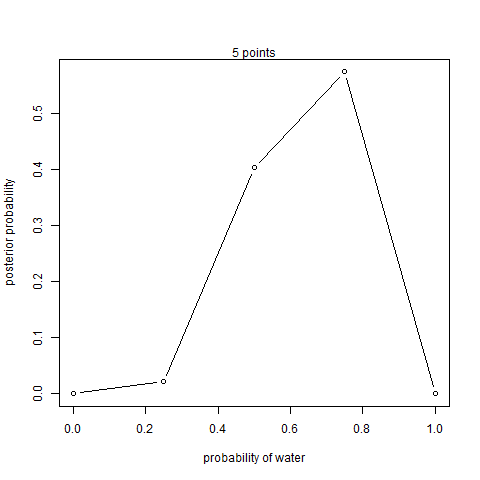

In [20]:
%%R 

# define grid
p_grid <- seq( from=0 , to=1 , length.out=5 )
# define prior
prior <- rep( 1 , 5 )
# compute likelihood at each value in grid
likelihood <- dbinom( 6 , size=9 , prob=p_grid )
# compute product of likelihood and prior
unstd.posterior <- likelihood * prior
# standardize the posterior, so it sums to 1
posterior <- unstd.posterior / sum(unstd.posterior)
 plot( p_grid , posterior , type="b" ,
xlab="probability of water" , ylab="posterior probability" )
mtext( "5 points" )

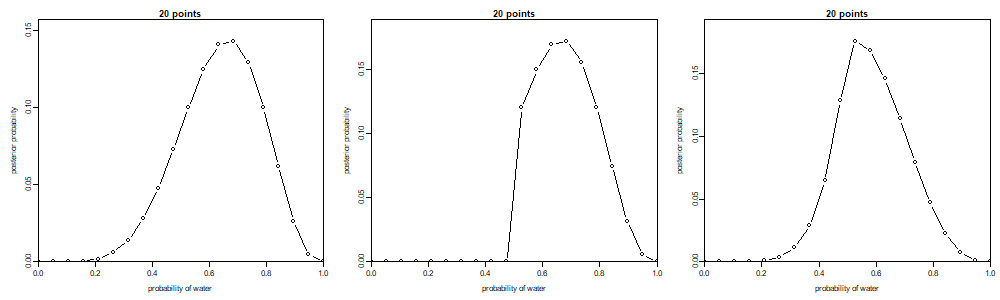

In [21]:
%%R -w 1000 -h 300

p_grid <- seq(0, 1, length.out = 20)

priors <- list(
  rep(1, 20),
  ifelse(p_grid < 0.5, 0, 1),
  exp(-5 * abs(p_grid - 0.5))
)

likelihood <- dbinom(6, 9, p_grid)

# cleaner plot style
par(mfrow=c(1,3),
    mar=c(4,4,2,1),
    mgp=c(2.2, 0.6, 0),
    tck=-0.02)

for (prior in priors) {
  
  unstd <- likelihood * prior
  posterior <- unstd / sum(unstd)
  
  plot(
    p_grid, posterior, type="b",
    pch=21, bg="white", cex=1.1,
    xlab="probability of water",
    ylab="posterior probability",
    ylim=c(0, max(posterior) * 1.1),
    xaxs="i", yaxs="i"
  )
  
  title("20 points", line=0.3, cex.main=1.1)
}


np.float64(0.6842105263157894)

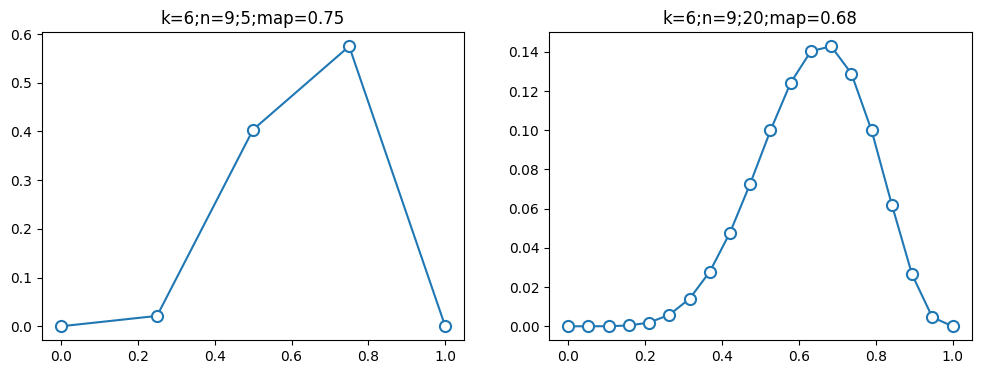

In [22]:
# grid approximation
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def grid_approx(k, n, resolution=20, ax=None, clip_prior=False):
    grid = np.linspace(0, 1, resolution)
    prior = np.ones(resolution)
    if clip_prior is not None:
        prior[grid < clip_prior] = 0
    lk = stats.binom.pmf(k, n, grid)
    unstd_post = lk * prior
    post = unstd_post / sum(unstd_post)
    mp = grid[post.argmax()]
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(
        grid, post,
        '-o',
        markerfacecolor='white',
        markersize=8,
        markeredgewidth=1.5,
        zorder=3,
    )
    
    ax.set_title(f'{k=};{n=};{resolution};map={mp:.2f}')
    return mp


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
grid_approx(6, 9, 5, ax=ax1)
grid_approx(6, 9, 20, ax=ax2)


### Ejercicios

ejercicio 2M1:

np.float64(0.7368421052631579)

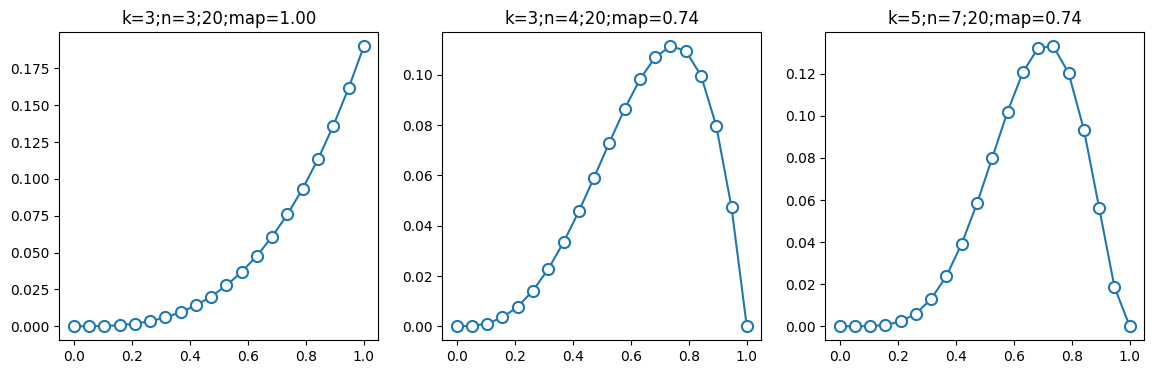

In [23]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 4])
grid_approx(3, 3, ax=ax1)
grid_approx(3, 4, ax=ax2)
grid_approx(5, 7, ax=ax3)


ejercicio 2M2

np.float64(0.7368421052631579)

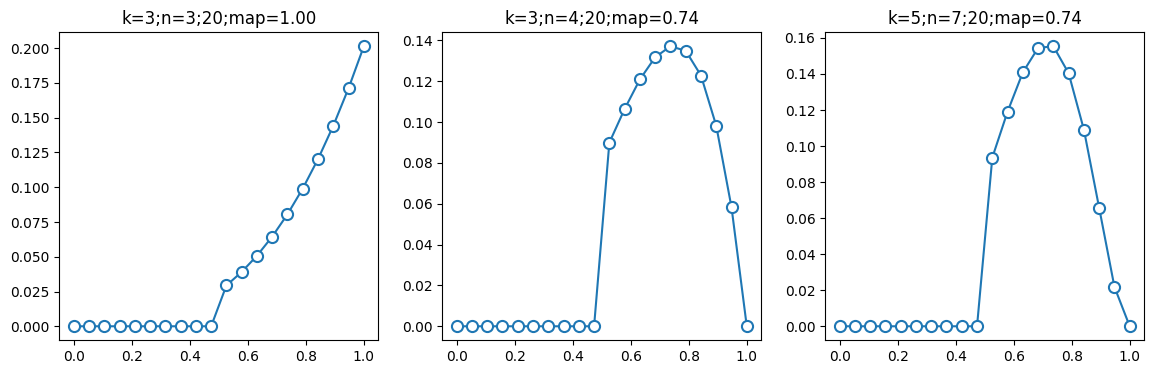

In [24]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 4])
grid_approx(3, 3, ax=ax1, clip_prior=0.5)
grid_approx(3, 4, ax=ax2, clip_prior=0.5)
grid_approx(5, 7, ax=ax3, clip_prior=0.5)

## Aproximación cuadrática.

In [25]:
%%R
library(rethinking) # McElreath lib
globe.qa <- quap( # quadratic approximation
    alist(
        W ~ dbinom( W+L ,p) , # binomial likelihood
        p ~ dunif(0,1) # uniform prior
    ),
    data=list(W=6,L=3) 
)

# display summary of quadratic approximation
precis( globe.qa )

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


Cargando paquete requerido: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Cargando paquete requerido: posterior
This is posterior version 1.6.1

Adjuntando el paquete: 'posterior'

The following objects are masked from 'package:stats':

    mad, sd, var

The following objects are masked from 'package:base':

    %in%, match

Cargando paquete requerido: parallel
rethinking (Version 2.42)

Adjuntando el paquete: 'rethinking'

The following object is masked from 'package:stats':

    rstudent



Podemos utilizar PyMC para calcular la aproximación.

Esto funciona para la versión 5 de PyMC.

En windows por alguna razón hay que correr dos veces la celda para que funcione. En la primera se genera un error al configurar el backend de pymc.


In [28]:
import pymc as pm
import scipy.stats as stats
W, L = 6, 3
N = W+L

with pm.Model() as globe_model: # definimos el modelo 
    p = pm.Uniform('p', 0, 1, default_transform=None)
    # Default transform None es vital o los estimadores serán
    # para el espacio no transformado y no corresponden con el libro
    lk = pm.Binomial('likelihood', observed=W, n=N, p=p)
    mp = pm.find_MAP(bounds=[(1e-9, 1-1e-9)], progressbar=0)
    # Los límites son requeridos para que el estimador converja apropiadamente
    # debajo del capote utiliza scipy minimize.
    hess = pm.find_hessian(
        mp,
        negate_output=False
        # en la versión actual de pymc (5)
        # esto es necesario para evitar errores y advertencias, 
        # aunque la consecuencia es que el resultado es negativo.
    )

sd = (1/-hess[0,0])**0.5
# como el resultado es negativo, utilizamos el menos unario para 
# hacerlo positivo "-hess"
map_point = mp['p']
# Por fin la aproximación normal
lo, hi = stats.norm.ppf([0.055, 0.945], loc=map_point, scale=sd)

print('mean', 'std', '5.5%', '94.5%')
print('p', *np.array([map_point, sd, lo, hi]).round(2))

mean std 5.5% 94.5%
p 0.67 0.16 0.42 0.92


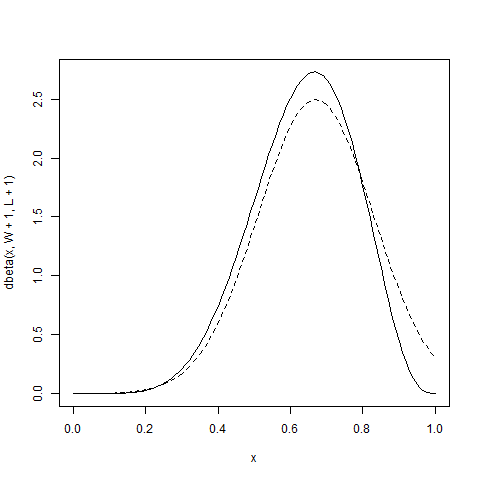

In [ ]:
%%R
W <- 6
L <- 3
curve( dbeta( x , W+1 , L+1 ) , from=0 , to=1 )
# quadratic approximation
curve( dnorm( x , 0.67 , 0.16 ) , lty=2 , add=TRUE )

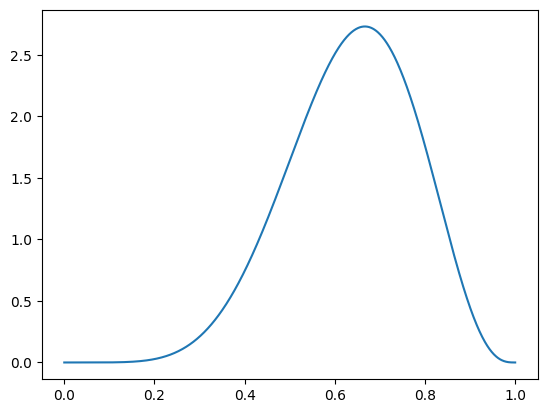

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = stats.beta.pdf(x, W+1, L+1)
plt.plot(x, y)

This is the beta posterior from observed data updating from a uniform distribution.

Full MCMC model:

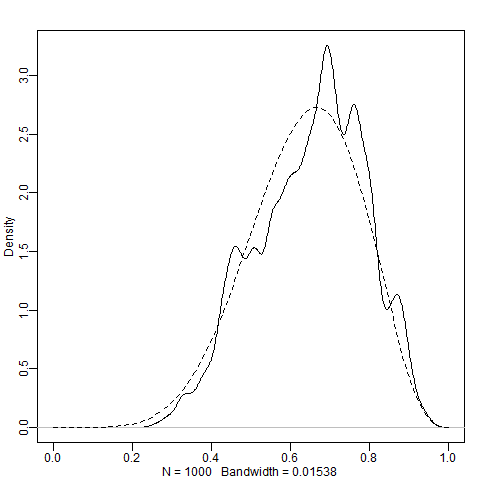

In [ ]:
%%R
n_samples <- 1000
p <- rep( NA , n_samples )
p[1] <- 0.5
W <- 6
L <- 3
for ( i in 2:n_samples ) {
p_new <- rnorm( 1 , p[i-1] , 0.1 )
    if ( p_new < 0 ) p_new <- abs( p_new )
    if ( p_new > 1 ) p_new <- 2 - p_new
    q0 <- dbinom( W , W+L , p[i-1] )
    q1 <- dbinom( W , W+L , p_new )
    p[i] <- ifelse( runif(1) < q1/q0 , p_new , p[i-1] )
}
dens( p , xlim=c(0,1) )
curve( dbeta( x , W+1 , L+1 ) , lty=2 , add=TRUE )

    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.636  0.14   0.381    0.888      0.004    0.002    1227.0    1276.0    1.0


<Axes: title={'center': 'p'}>

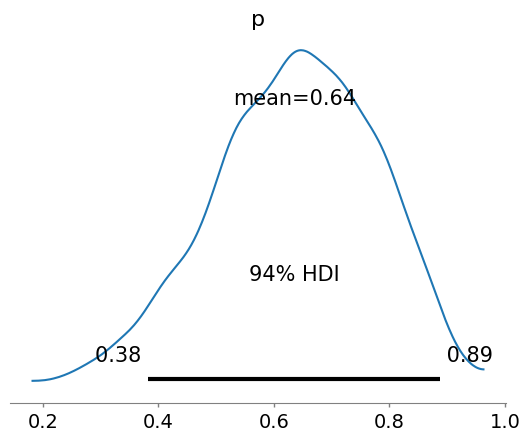

In [ ]:
import arviz as az
with pm.Model() as glob_model:
    p = pm.Beta('p', 1,1)
    lk = pm.Binomial('lk', p=p, n=W+L, observed=W)
    idata = pm.sample(nuts_sampler='blackjax', progressbar=None)
    # uso blackjax porque en windows el 
    # método por defacto genera errores de procesamiento en paralelo

print(az.summary(idata))
az.plot_posterior(idata)